# MOGPTK

### 1) Installation

### 2) Load Libraries

In [1]:
import sys
sys.path.insert(0, '../')
%reload_ext autoreload
%autoreload 2

import mogptk
#import gpflow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import scipy as sp
import math
import tensorflow as tf

from scipy.special import iv
from scipy.optimize import fsolve
from scipy.stats import vonmises
from scipy import stats
from scipy.stats import entropy
from scipy import interpolate

# plot config
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

### 3) Define Functions

In [2]:


def vonmises_density(x,mu,kappa):
    """
    Calculate the von Mises density for a series x (a 1D numpy.array).
    Input : 
        x : a 1D numpy.array of size L
        mu : a 1D numpy.array of size n, the mean of the von Mises distributions
        kappa : a 1D numpy.array of size n, the dispersion of the von Mises distributions
    Output : 
        a (L x n) numpy array, L is the length of the series, and n is the size of the array containing the parameters. Each row of the output corresponds to a density
    """
    res = []
    for i in x:
        f = np.exp(kappa*np.cos(i-mu))
        n = 2*np.pi*iv(0,kappa)
        res.append(f/n)
    return(np.array(res))

def vonmises_pdfit(series):
    """
    Calculate the estimator of the mean and deviation of a sample, for a von Mises distribution
    Input : 
        series : a 1D numpy.array
    Output : 
        the estimators of the parameters mu and kappa of a von Mises distribution, in an list [mu, kappa]
    """
    s0 = np.mean(np.sin(series))
    c0 = np.mean(np.cos(series))
    mu = np.arctan2(s0,c0)
    var = 1-np.sqrt(s0**2+c0**2)
    k = lambda kappa: 1-iv(1,kappa)/iv(0,kappa)-var
    kappa = fsolve(k, 0.0)[0]
    return([mu,kappa])

In [3]:
# Here is the function to define KL divergence
# Note: the samplepdf and observationpdf is the probability density function, not the sample count.

from scipy.stats import entropy

def kldiver(samplepdf, observationpdf):
    print("\nIndividual Entropy\n")
    print(entropy(samplepdf))
    print(entropy(observationpdf))

    print("\nPairwise Kullback Leibler divergence\n")
    firstkl = entropy(samplepdf, qk=observationpdf)
    secondkl = entropy(observationpdf, qk=samplepdf)
    print(firstkl)
    print(secondkl)
    return (firstkl,secondkl)

In [4]:
from scipy import interpolate

def invcdf(vals, pdf, num_sam):
    # Normalize
    normalize = pdf/np.sum(pdf)
    p = np.cumsum(normalize)
    # define inverse function
    inv_cdf = interpolate.interp1d(p,vals,bounds_error=False, fill_value = (-math.pi, math.pi))
    # get number of data
    r = np.random.rand(num_sam)
    # get sample
    sample = inv_cdf(r)
    return sample

In [5]:
# Here is the function to define the MSE
def countdiff(bins, sample, observation):
    if len(observation) != len(sample):
        print("Please generate the same length data")
    length = len(observation)
    sumup = 0
    sumup2 = 0
    # counts and divisions in the real data
    count,division = np.histogram(listall,range=(-math.pi,math.pi),bins=bins)
    # change the sample to numpy array, note: if it is already np array, comment it out
    s = sample
    # compute MSE
    for j in range(len(count)):
        modelCount = s[(division[j] < s) & (s < division[j+1])].size
        sumup += np.square(count[j] - modelCount)
        sumup2+= np.abs(count[j] - modelCount)
    mse = sumup/bins
    mae = sumup2/bins
    print('The MSE is ' + str(mse))
    print('The MAE is ' + str(mae))
    return mse, mae 

In [6]:
# Here is the function to define the MSE
def countdiffmse(bins, sample, observation):
    length = len(observation)
    sumup = 0
    sumup2 = 0
    # counts and divisions in the real data
    count,division = np.histogram(listall,range=(-math.pi,math.pi),bins=bins)
    # change the sample to numpy array, note: if it is already np array, comment it out
    s = sample
    # compute MSE
    for j in range(len(count)):
        modelCount = s[(division[j] < s) & (s < division[j+1])].size
        sumup += np.square(count[j] - modelCount)
        sumup2+= np.abs(count[j] - modelCount)
    mse = sumup/bins
    mae = sumup2/bins
    return mse

In [7]:
# Here is the function to define the MSE
def countdiffmae(bins, sample, observation):
    length = len(observation)
    sumup = 0
    sumup2 = 0
    # counts and divisions in the real data
    count,division = np.histogram(listall,range=(-math.pi,math.pi),bins=bins)
    # change the sample to numpy array, note: if it is already np array, comment it out
    s = sample
    # compute MSE
    for j in range(len(count)):
        modelCount = s[(division[j] < s) & (s < division[j+1])].size
        sumup += np.square(count[j] - modelCount)
        sumup2+= np.abs(count[j] - modelCount)
    mse = sumup/bins
    mae = sumup2/bins
    return mae

In [8]:
from scipy import stats

# Here is the function to define KL divergence
# Note: the samplepdf and observationpdf is the probability density function, not the sample count.

from scipy.stats import entropy

def kldiver2(samplepdf, observationpdf):
    #print("\nIndividual Entropy\n")
    #print(entropy(samplepdf))
    #print(entropy(observationpdf))

    #print("\nPairwise Kullback Leibler divergence\n")
    firstkl = entropy(samplepdf, qk=observationpdf)
    secondkl = entropy(observationpdf, qk=samplepdf)
    #print(firstkl)
    #print(secondkl)
    #return (firstkl,secondkl)
    return (firstkl+secondkl)/2

In [9]:
def converter(val):
    for i in range(0, len(val)):
        if (val[i] <=0):
            val[i] = 10E-300
    return val

### 4) Data

#### Load Data - Drop any unnecessary Columns you may have

In [10]:
df = pd.read_csv("/home/idies/workspace/Storage/Genius/TRF/0/sample.csv")
df = df.drop(columns=["Unnamed: 0"])
df.head()

,day,weekday,wakeup,firstMeal,lastMeal,sleep
0,1,Monday,5.94,8.05,17.83,21.08
1,2,Tuesday,6.02,7.99,17.87,21.16
2,3,Wednesday,6.19,8.22,18.05,21.14
3,4,Thursday,5.99,8.08,18.11,20.95
4,5,Friday,5.83,8.06,17.78,20.75


In [11]:
wake = df["wakeup"] * math.pi /12 - math.pi
sleep = df["sleep"] * math.pi /12 - math.pi
meal1 = df["firstMeal"] * math.pi /12 - math.pi
meal2 = df["lastMeal"] * math.pi /12 - math.pi

wake_val = vonmises_pdfit(wake)
sleep_val = vonmises_pdfit(sleep)
food1 = vonmises_pdfit(meal1)
food2 = vonmises_pdfit(meal2)

### 5) MOGPTK

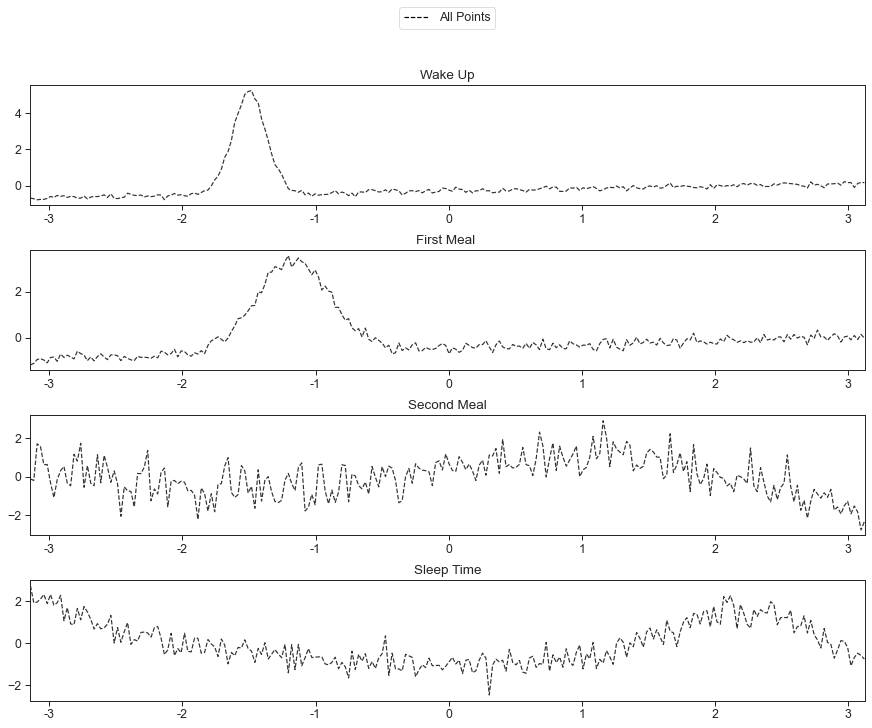

In [12]:
# Create toy data set.
n = 1000
x = np.linspace(-math.pi, math.pi, n)
noise = 0.05

# Draw functions depending on each other in complicated ways.
# Wake
f1 = vonmises_density(x,wake_val[0],wake_val[1])
a1 = vonmises.rvs(wake_val[1],wake_val[0], size = 100)
# Food
food_val_a1 = vonmises_pdfit(list(meal1) +list(a1))
f2 = vonmises_density(x,food_val_a1[0],food_val_a1[1])
a2 = vonmises.rvs(food_val_a1[1],food_val_a1[0], size = 100)

food_val_a2 = vonmises_pdfit(list(meal2) +list(a2))
f3 = vonmises_density(x,food_val_a2[0],food_val_a2[1])
a3 = vonmises.rvs(food_val_a2[1],food_val_a2[0], size = 100)

# Sleep 
sleep_val_b = vonmises_pdfit(list(sleep) + list(a3))
f4 = vonmises_density(x,sleep_val_b[0],sleep_val_b[1])

f = np.stack((f1, f2, f3, f4), axis=0).T

# Add noise and subsample.
y = f + noise * np.random.randn(n, 4)
x_obs, y_obs = x[::4], y[::4]

data0 = mogptk.Data(x_obs,y_obs[:,0],name ='Wake Up')
data1 = mogptk.Data(x_obs,y_obs[:,1],name ='First Meal ')
data2 = mogptk.Data(x_obs,y_obs[:,2],name ='Second Meal')
data3 = mogptk.Data(x_obs,y_obs[:,3],name ='Sleep Time')

dataset = mogptk.DataSet(data0,data1,data2,data3)

for channel in dataset:
    channel.transform(mogptk.TransformDetrend(degree=1))
    channel.transform(mogptk.TransformWhiten())
dataset.plot();

####  5.1) Applying the MOSM method ( multi-output spectral mixture)

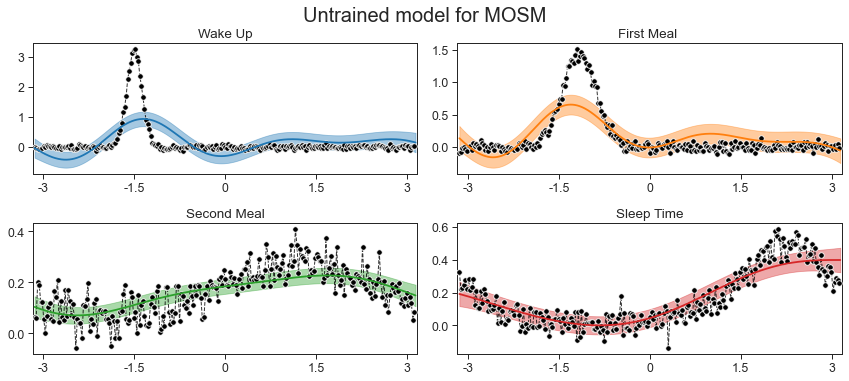

In [13]:
model_mosm = mogptk.MOSM(dataset, Q=2)

# initialize parameters of kernel
model_mosm.init_parameters()
model_mosm.print_parameters()

# plot the prediction with untrained model
x_pred = [x for i in range(len(dataset))]
model_mosm.predict(x_pred);

model_mosm.plot_prediction(title='Untrained model for MOSM');

In [14]:
model_mosm.train(
    method='L-BFGS-B',
    tol=1e-60,
    maxiter=500,
    verbose=True)

Starting optimization
 >Model: MOSM
 >Channels: 4                    
 >Components: 2
 >Training points: 1000
 >Parameters: 45
 >Initial NLL: 1247.818
Optimization finished in 2.00 minutes
 >Final NLL: 156.084 



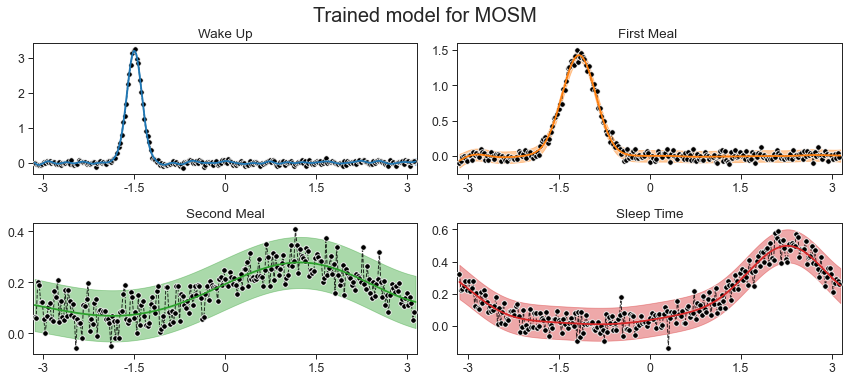

In [15]:
model_mosm.predict();

#model.plot_prediction(title='Trained model');
#model.predict(x_pred)
model_mosm.plot_prediction(title='Trained model for MOSM');

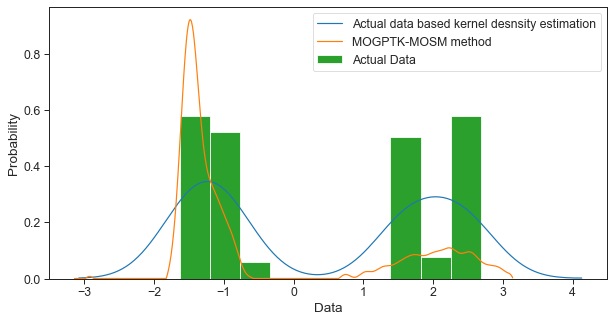

In [16]:
w1=model_mosm.predict()
listall = list(wake) + list(sleep) + list(meal1) + list(meal2)
actual_density = stats.kde.gaussian_kde(listall)
actual_density = actual_density(x)

#actual_density = actual_density[::8]
wn =(w1[1][0]+w1[1][1]+w1[1][2]+w1[1][3])/4
converter(wn);

sns.kdeplot(listall,label='Actual data based kernel desnsity estimation')
plt.plot(x, wn, label = 'MOGPTK-MOSM method')
plt.hist(listall,density=True,label='Actual Data')
plt.ylabel('Probability')
plt.xlabel('Data')
plt.legend()

In [17]:
kl = []
samples = invcdf(x,wn, len(listall))
kl_density2 = stats.kde.gaussian_kde(samples)
kl_density2 = kl_density2(x)
print("\nIndividual Entropy\n")
print(kldiver(kl_density2, actual_density))



Individual Entropy


Individual Entropy

6.339966003974945
6.574349975317222

Pairwise Kullback Leibler divergence

0.17799379404406768
0.1870005155498084
(0.17799379404406768, 0.1870005155498084)


In [18]:
papermse = []
papermae = []
for i in range(1000):
    samples = invcdf(x,wn, len(listall))
    papermse.append(countdiffmse(48,samples, listall))
    papermae.append(countdiffmae(48,samples, listall))

In [19]:
meanmse = np.mean(papermse)
meanmae = np.mean(papermae)
lowersmse = np.percentile(papermse, 2.5)
uppersmse = np.percentile(papermse, 100 - 2.5)
lowersmae = np.percentile(papermae, 2.5)
uppersmae = np.percentile(papermae, 100 - 2.5)

print("MSE mean is " + str(meanmse))
print("MSE lower is " + str(lowersmse))
print("MSE upper is " + str(uppersmse))

print("MAE mean is " + str(meanmae))
print("MAE lower is " + str(lowersmae))
print("MAE upper is " + str(uppersmae))

MSE mean is 575.9899583333332
MSE lower is 485.4145833333333
MSE upper is 675.7541666666667
MAE mean is 12.428583333333332
MAE lower is 11.498958333333334
MAE upper is 13.416666666666666


#### 5.2) Applying the CSM method (Cross Spectral Mixture)

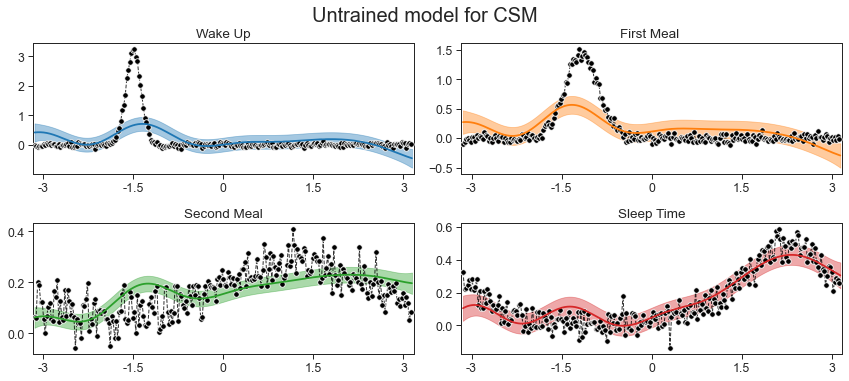

In [20]:

model_csm = mogptk.CSM(dataset, Q=2)

# initialize parameters of kernel
model_csm.init_parameters()
model_csm.print_parameters()

# plot the prediction with untrained model
x_pred = [x for i in range(len(dataset))]
model_csm.predict(x_pred);

model_csm.plot_prediction(title='Untrained model for CSM');

In [21]:
model_csm.train(
    method='L-BFGS-B',
    tol=1e-60,
    maxiter=500,
    verbose=True)

Starting optimization
 >Model: CSM
 >Channels: 4                    
 >Components: 2
 >Training points: 1000
 >Parameters: 25
 >Initial NLL: 1313.715
Optimization finished in 1.69 minutes
 >Final NLL: 227.021 



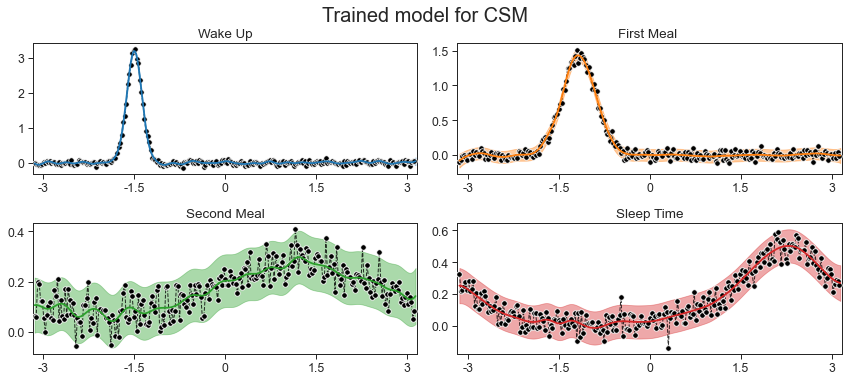

In [22]:
model_csm.predict();

#model.plot_prediction(title='Trained model');
#model.predict(x_pred)
model_csm.plot_prediction(title='Trained model for CSM');

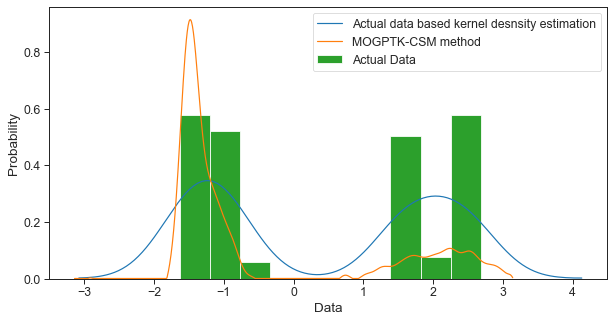

In [23]:
w1=model_csm.predict()
listall = list(wake) + list(sleep) + list(meal1) + list(meal2)
actual_density = stats.kde.gaussian_kde(listall)
actual_density = actual_density(x)

#actual_density = actual_density[::8]
wn =(w1[1][0]+w1[1][1]+w1[1][2]+w1[1][3])/4
converter(wn);

sns.kdeplot(listall,label='Actual data based kernel desnsity estimation')
plt.plot(x, wn, label = 'MOGPTK-CSM method')
plt.hist(listall,density=True,label='Actual Data')
plt.ylabel('Probability')
plt.xlabel('Data')
plt.legend()

In [24]:
kl = []
samples = invcdf(x,wn, len(listall))
kl_density2 = stats.kde.gaussian_kde(samples)
kl_density2 = kl_density2(x)
print("\nIndividual Entropy\n")
print(kldiver(kl_density2, actual_density))


Individual Entropy


Individual Entropy

6.347484758693981
6.574349975317222

Pairwise Kullback Leibler divergence

0.17043790121768723
0.18359302220282492
(0.17043790121768723, 0.18359302220282492)


In [25]:
papermse = []
papermae = []
for i in range(1000):
    samples = invcdf(x,wn, len(listall))
    papermse.append(countdiffmse(48,samples, listall))
    papermae.append(countdiffmae(48,samples, listall))

In [26]:
meanmse = np.mean(papermse)
meanmae = np.mean(papermae)
lowersmse = np.percentile(papermse, 2.5)
uppersmse = np.percentile(papermse, 100 - 2.5)
lowersmae = np.percentile(papermae, 2.5)
uppersmae = np.percentile(papermae, 100 - 2.5)

print("MSE mean is " + str(meanmse))
print("MSE lower is " + str(lowersmse))
print("MSE upper is " + str(uppersmse))

print("MAE mean is " + str(meanmae))
print("MAE lower is " + str(lowersmae))
print("MAE upper is " + str(uppersmae))

MSE mean is 589.5045833333332
MSE lower is 495.75625
MSE upper is 686.4697916666667
MAE mean is 12.485416666666666
MAE lower is 11.541666666666668
MAE upper is 13.417708333333332


 #### Applying the SM-LMC Method (Spectral Mixture - Linear Model of Coregionalization)

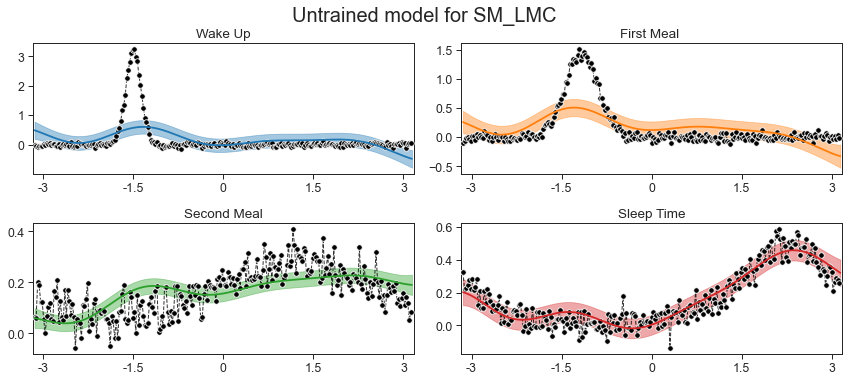

In [27]:

model_smlmc = mogptk.SM_LMC(dataset, Q=2)

# initialize parameters of kernel
model_smlmc.init_parameters()
model_smlmc.print_parameters()

# plot the prediction with untrained model
x_pred = [x for i in range(len(dataset))]
model_smlmc.predict(x_pred);

model_smlmc.plot_prediction(title='Untrained model for SM_LMC');

In [28]:
model_smlmc.train(
    method='L-BFGS-B',
    tol=1e-60,
    maxiter=500,
    verbose=True)

Starting optimization
 >Model: SM-LMC
 >Channels: 4                    
 >Components: 2
 >Training points: 1000
 >Parameters: 17
 >Initial NLL: 1301.373
Optimization finished in 0.54 minutes
 >Final NLL: 746.814 



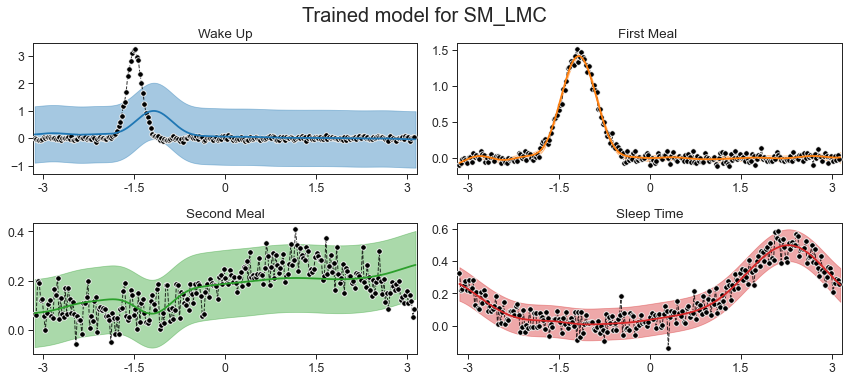

In [29]:
model_smlmc.predict();

#model.plot_prediction(title='Trained model');
#model.predict(x_pred)
model_smlmc.plot_prediction(title='Trained model for SM_LMC');

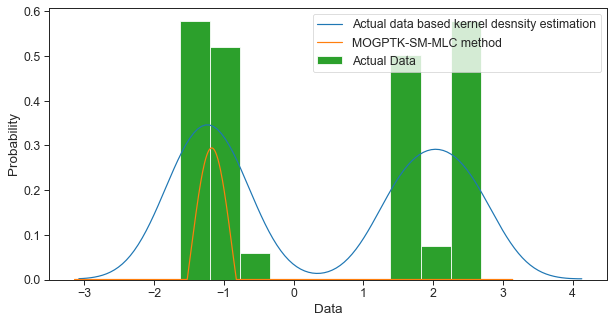

In [30]:
w1=model_smlmc.predict()
listall = list(wake) + list(sleep) + list(meal1) + list(meal2)
actual_density = stats.kde.gaussian_kde(listall)
actual_density = actual_density(x)

#actual_density = actual_density[::8]
wn =(w1[1][0]+w1[1][1]+w1[1][2]+w1[1][3])/4
converter(wn);

sns.kdeplot(listall,label='Actual data based kernel desnsity estimation')
plt.plot(x, wn, label = 'MOGPTK-SM-MLC method')
plt.hist(listall,density=True,label='Actual Data')
plt.ylabel('Probability')
plt.xlabel('Data')
plt.legend()

In [31]:
kl = []
samples = invcdf(x,wn, len(listall))
kl_density2 = stats.kde.gaussian_kde(samples)
kl_density2 = kl_density2(x)
print("\nIndividual Entropy\n")
print(kldiver(kl_density2, actual_density))


Individual Entropy


Individual Entropy

4.620159497233221
6.574349975317222

Pairwise Kullback Leibler divergence

1.4977505673638374
inf
(1.4977505673638374, inf)


In [32]:
papermse = []
papermae = []
for i in range(1000):
    samples = invcdf(x,wn, len(listall))
    papermse.append(countdiffmse(48,samples, listall))
    papermae.append(countdiffmae(48,samples, listall))

In [33]:
meanmse = np.mean(papermse)
meanmae = np.mean(papermae)
lowersmse = np.percentile(papermse, 2.5)
uppersmse = np.percentile(papermse, 100 - 2.5)
lowersmae = np.percentile(papermae, 2.5)
uppersmae = np.percentile(papermae, 100 - 2.5)

print("MSE mean is " + str(meanmse))
print("MSE lower is " + str(lowersmse))
print("MSE upper is " + str(uppersmse))

print("MAE mean is " + str(meanmae))
print("MAE lower is " + str(lowersmae))
print("MAE upper is " + str(uppersmae))

MSE mean is 1674.4715833333335
MSE lower is 1568.153125
MSE upper is 1781.3041666666668
MAE mean is 19.003708333333336
MAE lower is 18.583333333333332
MAE upper is 19.458333333333332
